# Exercise: Babylonian Square Root

## Algorithm + Numerical precision

The Babylonians introduced a simple but clever iterative algorithm for computing the square root of a number:

> Repeat $t \leftarrow (t + x/t)/2$ until $t$ converges to $\sqrt{x}$.

Here a Julia implementation that performs the iterative procedure `N` times.

In [1]:
function sqrt_babylonian(x, N = 10)
    t = (1+x)/2
    for i = 2:N
        t = (t + x/t)/2
    end
    t
end

sqrt_babylonian (generic function with 2 methods)

**Tasks**

1. Confirm that the iterative algorithm indeed converges to the square root by comparing the output of `sqrt_babylonian` to `sqrt(big"2.0")` for `N` increasing from `1` to `10`. (Here, `big"2.0"` creates a `BigFloat` which has arbitrarily high precision.)
    - How big is the difference to the "exact" result?
    - Does increasing `N` any further help?
2. Do the same as in task 1 but vary the data type of the input number. Specifically, use `Float16(2.0)`, `Float32(2.0)`, `Float64(2.0)`, and `big"2.0"` (`BigFloat`).

In [2]:
# 1.
using Plots

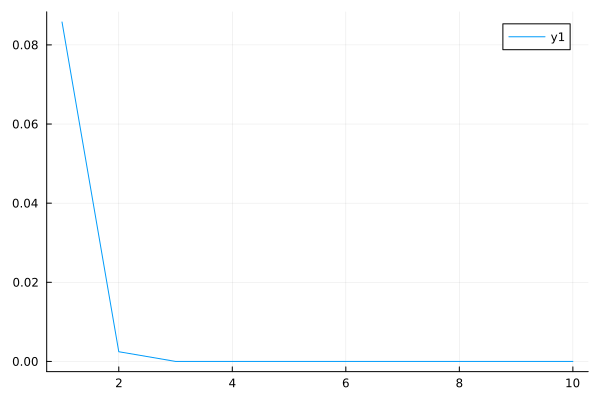

In [4]:
sq2 = sqrt(big"2.0")

approx = [sqrt_babylonian(big"2.0", i) for i in 1:10]

plot(approx.-sq2)

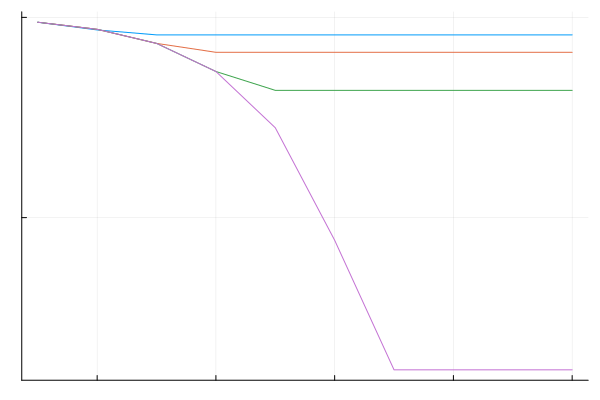

In [21]:
# 2.
approx_f16 = [sqrt_babylonian(Float16(2.0), i) for i in 1:10]
approx_f32 = [sqrt_babylonian(Float32(2.0), i) for i in 1:10]
approx_f64 = [sqrt_babylonian(Float64(2.0), i) for i in 1:10]
plot(abs.(approx_f16.-sq2), label="f16", yscale=:ln)
plot!(abs.(approx_f32.-sq2), label="f32", yscale=:ln)
plot!(abs.(approx_f64.-sq2), label="f64", yscale=:ln)
plot!(abs.(approx.-sq2), label="big", yscale=:ln)

The fact that our generic implementation of the babylonian square root algorithm can be executed with different numerical precisions is only a specific case of a more general concept: The combination of generic code and special data types can lead to "emergent" features. Below, we'll consider three simple but hopefully somewhat exciting examples that will make our `sqrt_babylonian`
* compute not only the square root itself but also its derivative,
* produce an analytical expression that approximates the square root, and
* propagate uncertainty in the input (according to linear error propagation theory) to the output.

And all of this **without modifying our `sqrt_babylonian` implementation above at all**.

## Automatic differentiation
A powerful number type invented by Clifford in 1873 is the [*dual number*](https://en.wikipedia.org/wiki/Dual_number). One application of these numbers is what is known as forward-mode automatic differentiation (AD) these days. Here a simple Julia implementation:

In [22]:
# D for "dual number", invented by Clifford in 1873.
struct D <: Number
    x::Float64 # value
    ϵ::Float64 # derivative
end

Base.:+(a::D, b::D) = D(a.x + b.x, a.ϵ + b.ϵ) # sum rule
Base.:-(a::D, b::D) = D(a.x - b.x, a.ϵ - b.ϵ) # sum rule
Base.:*(a::D, b::D) = D(a.x * b.x, a.x * b.ϵ + a.ϵ * b.x) # product rule
Base.:/(a::D, b::D) = D(a.x / b.x, (b.x * a.ϵ - a.x * b.ϵ)/b.x^2) # quotient rule

# Conversion and promotion of regular numbers to dual numbers
Base.convert(::Type{D}, x::Real) = D(x, zero(x))
Base.promote_rule(::Type{D}, ::Type{<:Number}) = D

The derivative of a generic Julia function (that fundamentally relies on `+`, `-`, `*`, and `/`) can know be obtained with the following function

In [23]:
# utility function for our small forward-mode AD
derivative(f::Function, x::Number) = f(D(x, one(x))).ϵ

derivative (generic function with 1 method)

**Tasks**

3. What is the analytical derivative of $\sqrt{x}$ (try to remember your calculus class 😉)?

4. Check that `derivative(sqrt_babylonian, some_number)` indeed automagically gives the correct value of the derivative.
    - Feel free to try other functions/algorithms as well! Maybe something recursive like `pow(x, n) = n <= 0 ? 1 : x*pow(x, n-1)`?

In [26]:
# 4.
println("Derivative: $(derivative(sqrt_babylonian, 2.0))")
println("Error: $(derivative(sqrt_babylonian, 2.0)-1/(2*sqrt(2)))")

Derivative: 0.35355339059327373
Error: 0.0


## Symbolics

Now, imagine your supervisor coming to your office and telling you that he thinks that the Babylonian approximation for `N=3` is equivalent to the analytical form
$$ \text{sqrt\_babylonian}(x, 3) \approx \begin{equation}
\frac{7 x + 17 x^{2} + 7 x^{3}}{8 \left( 1 + x \right) \left( \frac{1}{4} + \frac{3}{2} x + \frac{1}{4} x^{2} \right)}
\end{equation} $$

Of course, he asks you to quickly confirm this.

**Tasks**

5. Is your supervisor correct?
    - Hint: Use the `Symbolics` package, in particular `@variables x` and `simplify`.
    - Note: Make sure you have `N=3` since for larger `N` problems might start to occur.

In [34]:
# 5.
using Symbolics

In [36]:
@variables x
simplify(sqrt_babylonian(x, 3))

(7x + 17(x^2) + 7(x^3)) / (8(1 + x)*((1//4) + (3//2)*x + (1//4)*(x^2)))

## Uncertainty propagation

In the experimental sciences, numerical values (e.g., from measurements) are often subject to uncertainties due to systematic precision errors of the measurement devices. The Julia package [Measurements.jl](https://github.com/JuliaPhysics/Measurements.jl) provides a number type and corresponding arithmetical operations that address this situation. Specifically, the package implements linear error propagation theory, which states that given a function $f(x)$ and an input value $x_0$ with uncertainty $\Delta x_0$, the uncertainty of $f(x_0)$ is given by
$$
\Delta (f(x_0)) = \dfrac{df}{dx}(x_0) \cdot \Delta x_0,
$$
that is, the derivative of $f$ evaluated at $x_0$ multiplied by the input uncertainty $\Delta x_0$.

In [37]:
# Example:
using Measurements

x = 1.2 ± 0.1 # you can get the ± by typing \pm and then pressing the "TAB" key.
y = 3.4 ± 0.2

x + y

4.6 ± 0.22

**Tasks**

6. Try to run our sqrt algorithm with a `Measurement` as input, i.e. `sqrt_babylonian(2.0 ± 0.1)`.
    - Does it work?
    - What uncertainy do you get for the result?
7. It never hurts to check for correctness: Does the obtained uncertainty match the formula above for $f=\textrm{sqrt}$?

In [38]:
# 6..
sqrt_babylonian(2.0 ± .1)

1.414 ± 0.035

In [39]:
# 7.
1/(2*sqrt(2))*0.1

0.035355339059327376